# 1. Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# change working directory
%cd /Users/qing/Google\ Drive/Fall\ 2019/STAT\ 5990\:6690\ Big\ Data\ Analysis\ Using\ Python/Final\ Project/smsspamcollection

/Users/qing/Google Drive/Fall 2019/STAT 5990:6690 Big Data Analysis Using Python/Final Project/smsspamcollection


In [3]:
# import txt file
spamSMS = pd.read_csv("SMSSpamCollection.txt", names=["label", "message"],
                     sep="\t")

In [4]:
spamSMS.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
spamSMS.shape

(5572, 2)

In [6]:
# One-hot coding for "label" with "spam" = 1, 
spamSMS["label"]  = [1 if each == "spam" else 0 for each in spamSMS["label"]]

In [7]:
spamSMS.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# 2. Data Visualization

In [8]:
# ! pip install wordcloud

## 2.1. Word Cloud for spam message

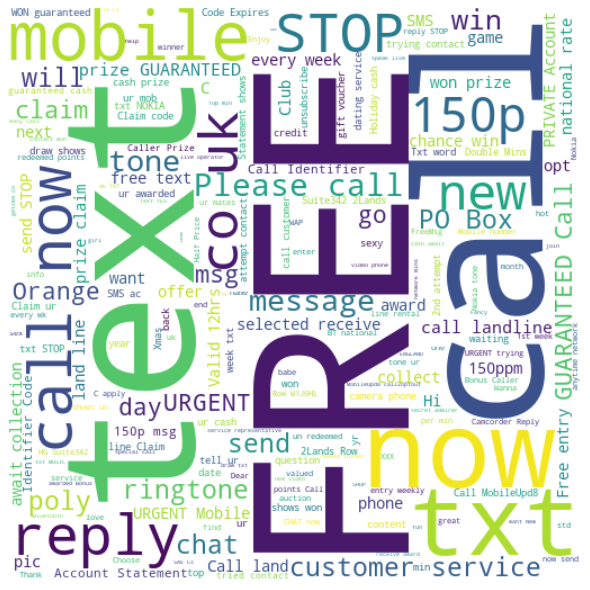

In [9]:
from wordcloud import WordCloud
spam_words = ' '.join(list(spamSMS[spamSMS["label"]==1]["message"]))
spam_wc = WordCloud(width=512,height=512,background_color="white").generate(spam_words)
plt.figure(figsize=(10,8))
plt.imshow(spam_wc, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## 2.2. Word Cloud for normal message

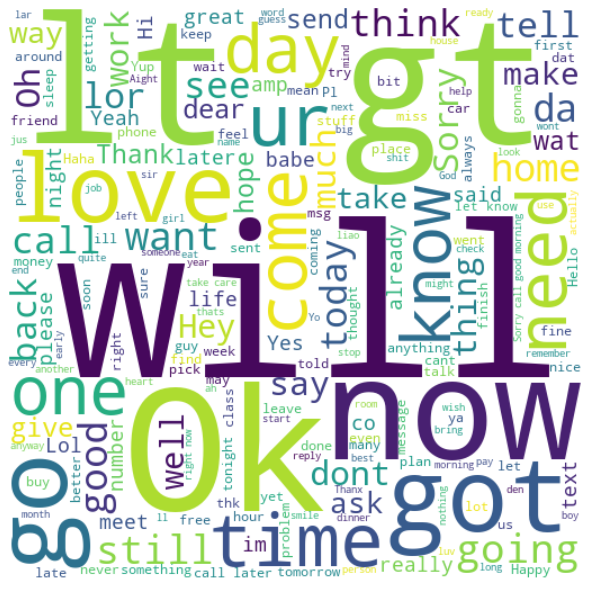

In [10]:
from wordcloud import WordCloud
ham_words = ' '.join(list(spamSMS[spamSMS["label"]==0]["message"]))
ham_wc = WordCloud(width=512,height=512,background_color="white").generate(ham_words)
plt.figure(figsize=(10,8))
plt.imshow(ham_wc, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

From the two word clouds above, we can see that different word structures of "spam" and "ham" can be used to distinguish messages.

# 3. Create Feature Matrix

## 3.1. Bag of Words (BOW) model

### 3.1.1. Choose 1 message to create document frequency matrix (DFM) as an experiment

#### 3.1.1.1. Preprocessing

In [11]:
'''
We choose 1 message to create document frequency matrix (DFM).
'''
ex_sms = spamSMS.loc[2,"message"]
ex_sms

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

In [12]:
# Throw any non-characters, like puctuation and numbers
import re
ex_sms = re.sub("[^a-zA-Z]"," ", ex_sms)
# ex_sms = re.sub(r"\W"," ", ex_sms)  # remove punctuation
ex_sms

'Free entry in   a wkly comp to win FA Cup final tkts   st May       Text FA to       to receive entry question std txt rate T C s apply            over   s'

In [13]:
# Removing multiple spaces
ex_sms = re.sub(r"\s+"," ",ex_sms)
ex_sms

'Free entry in a wkly comp to win FA Cup final tkts st May Text FA to to receive entry question std txt rate T C s apply over s'

In [14]:
# Stemming
from nltk.stem import SnowballStemmer
stem = SnowballStemmer('english')
ex_sms = ' '.join(stem.stem(word) for word in str(ex_sms).split())
ex_sms

'free entri in a wkli comp to win fa cup final tkts st may text fa to to receiv entri question std txt rate t c s appli over s'

#### 3.1.1.2. Derive document frenquency matrix (DFM)

In [15]:
# Derive document frenquency matrix (DFM), with lowercase, stopwords applied
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=True, stop_words='english')
smsMat = vectorizer.fit_transform([ex_sms])

In [16]:
vectorizer.get_feature_names()

['appli',
 'comp',
 'cup',
 'entri',
 'fa',
 'final',
 'free',
 'question',
 'rate',
 'receiv',
 'st',
 'std',
 'text',
 'tkts',
 'txt',
 'win',
 'wkli']

In [17]:
smsMat.toarray()

array([[1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [18]:
smsSer_bow = pd.DataFrame(smsMat.toarray(), columns=vectorizer.get_feature_names())
smsSer_bow

,appli,comp,cup,entri,fa,final,free,question,rate,receiv,st,std,text,tkts,txt,win,wkli
0,1,1,1,2,2,1,1,1,1,1,1,1,1,1,1,1,1


### 3.1.2. Loop all procedures above to create DFM for all messages

#### 3.1.2.1. Preprocessing

In [34]:
import re
from nltk.stem import SnowballStemmer

sms_list = []
for sms in spamSMS["message"]:
    sms = re.sub("[^a-zA-Z]"," ", sms) # remove punctuation and numbers
    sms = re.sub(r"\s+"," ",sms) # remove multiple spaces
    stem = SnowballStemmer('english')
    sms = ' '.join(stem.stem(word) for word in str(sms).split()) # stemming
    sms_list.append(sms)
    

#### 3.1.2.2. Derive document frenquency matrix (DFM)

In [20]:
'''
Derive document frenquency matrix (DFM), limit features to 3000 (some
words with very low frequency would be deleted),
with lowercase transformation, stopwords removal applied
'''

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=True, stop_words='english',
                            max_features=3000)
smsMat = vectorizer.fit_transform(sms_list)
words = vectorizer.get_feature_names()
sparceMat = smsMat.toarray()
smsDf_bow = pd.DataFrame(sparceMat, columns=words)
smsDf_bow

,aah,aathi,abi,abiola,abl,absolut,abt,abta,ac,acc,...,yoga,yogasana,yor,yr,yrs,yummi,yun,yuo,yup,zed
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3.2. TF-IDF model

TF-IDF is used to increase weights of words with more classifying power, i.e. those words frequently appears in many messages would have lower weights. 

In [21]:
'''
Directly use preprocessed text list above to create TF-IDF, limit 
features to 3000, with lowercase transformation, stopwords removal applied. 
'''
'''
"smooth_idf=True" is used to prevent zero division. 
For more information about sklearn TfidfVectorizer, please refer to: 
https://scikit-learn.org/stable/modules/feature_extraction.html
#text-feature-extraction
'''

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english',
                            smooth_idf=True, max_features=3000)
smsMat = vectorizer.fit_transform(sms_list)
words = vectorizer.get_feature_names()
sparceMat = smsMat.toarray()
smsDf_tfidf = pd.DataFrame(sparceMat, columns=words)
smsDf_tfidf

,aah,aathi,abi,abiola,abl,absolut,abt,abta,ac,acc,...,yoga,yogasana,yor,yr,yrs,yummi,yun,yuo,yup,zed
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english',
                            smooth_idf=True)
smsMat = vectorizer.fit_transform([ex_sms])
words = vectorizer.get_feature_names()
sparceMat = smsMat.toarray()
smsSer_tfidf = pd.DataFrame(sparceMat, columns=words)
smsSer_tfidf

,appli,comp,cup,entri,fa,final,free,question,rate,receiv,st,std,text,tkts,txt,win,wkli
0,0.208514,0.208514,0.208514,0.417029,0.417029,0.208514,0.208514,0.208514,0.208514,0.208514,0.208514,0.208514,0.208514,0.208514,0.208514,0.208514,0.208514


## 3.3. N-Grams Model (bigram)

N-grams is a sementic improvement on top of the above two methods, since some phrases would be more meaningful than single words.

### 3.3.1. TF-IDF_bigram

In [23]:
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english',
                            ngram_range=(1, 2), smooth_idf=True)
smsMat = vectorizer.fit_transform([ex_sms])
words = vectorizer.get_feature_names()
sparceMat = smsMat.toarray()
smsSer_tfidf_bigram = pd.DataFrame(sparceMat, columns=words)
smsSer_tfidf_bigram

,appli,comp,comp win,cup,cup final,entri,entri question,entri wkli,fa,fa cup,...,text,text fa,tkts,tkts st,txt,txt rate,win,win fa,wkli,wkli comp
0,0.156174,0.156174,0.156174,0.156174,0.156174,0.312348,0.156174,0.156174,0.312348,0.156174,...,0.156174,0.156174,0.156174,0.156174,0.156174,0.156174,0.156174,0.156174,0.156174,0.156174


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english',
            ngram_range=(1, 2),smooth_idf=True, max_features=3000)
smsMat = vectorizer.fit_transform(sms_list)
words = vectorizer.get_feature_names()
sparceMat = smsMat.toarray()
smsDf_tfidf_bigram = pd.DataFrame(sparceMat, columns=words)
smsDf_tfidf_bigram

,aathi,abi,abiola,abl,abt,ac,acc,accept,accept day,access,...,yogasana,yr,yr prize,yrs,yun,yuo,yup,yup ok,yup thk,zed
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.3.2. BOW_bigram

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=True, stop_words='english',
                            ngram_range=(1, 2), max_features=3000)
smsMat = vectorizer.fit_transform(sms_list)
words = vectorizer.get_feature_names()
sparceMat = smsMat.toarray()
smsDf_bow_bigram = pd.DataFrame(sparceMat, columns=words)
smsDf_bow_bigram

,aathi,abi,abiola,abl,abt,ac,acc,accept,accept day,access,...,yogasana,yr,yr prize,yrs,yun,yuo,yup,yup ok,yup thk,zed
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
vectorizer = CountVectorizer(lowercase=True, stop_words='english',
                            ngram_range=(1, 2))
smsMat = vectorizer.fit_transform([ex_sms])
words = vectorizer.get_feature_names()
sparceMat = smsMat.toarray()
smsSer_bow_bigram = pd.DataFrame(sparceMat, columns=words)
smsSer_bow_bigram

,appli,comp,comp win,cup,cup final,entri,entri question,entri wkli,fa,fa cup,...,text,text fa,tkts,tkts st,txt,txt rate,win,win fa,wkli,wkli comp
0,1,1,1,1,1,2,1,1,2,1,...,1,1,1,1,1,1,1,1,1,1


# 4. Model Evaluation

We apply several methods on the 4 kinds of dataframes we created above. By using cross-validation, we can judge which dataframe is best for prediction.

In [27]:
smsDf = [smsDf_bow, smsDf_tfidf, smsDf_tfidf_bigram, smsDf_bow_bigram]

## 4.1. Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(random_state=1)
from sklearn.model_selection import cross_val_score
logit_cv = np.zeros(4)
for i in range(4):
    logit.fit(smsDf[i], spamSMS["label"])
    logit_cv[i] = np.mean(cross_val_score(logit, smsDf[i], spamSMS["label"],
                              scoring='accuracy', cv=10))
print(logit_cv)

/Users/qing/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/qing/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/qing/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/qing/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/qing/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be ch

/Users/qing/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/qing/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/qing/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/qing/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.98312867 0.96644042 0.96966977 0.98420619]


/Users/qing/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


From the results above, we can see bow and bow_bigram perform better.

## 4.2. KNN

In [29]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
from sklearn.model_selection import cross_val_score
knn_cv = np.zeros(4)
for i in range(4):
    knn.fit(smsDf[i], spamSMS["label"])
    knn_cv[i] = np.mean(cross_val_score(knn, smsDf[i], spamSMS["label"],
                              scoring='accuracy', cv=5))
print(knn_cv)

[0.93664748 0.93054544 0.93144263 0.93628809]


From the results above, we can see bow and bow_bigram perform better.

## 4.3. Gaussian Naive Bayesian

In [30]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
from sklearn.model_selection import cross_val_score
gnb_cv = np.zeros(4)
for i in range(4):
    gnb.fit(smsDf[i], spamSMS["label"])
    gnb_cv[i] = np.mean(cross_val_score(gnb, smsDf[i], spamSMS["label"],
                              scoring='accuracy', cv=5))
print(gnb_cv)

[0.86234762 0.85750183 0.85983528 0.85893794]


From the results above, we can see bow performs better.

## 4.4. Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(random_state=1, n_jobs=3)
from sklearn.model_selection import cross_val_score
forest_cv = np.zeros(4)
for i in range(4):
    forest.fit(smsDf[i], spamSMS["label"])
    forest_cv[i] = np.mean(cross_val_score(forest, smsDf[i], spamSMS["label"],
                              scoring='accuracy', cv=5))
print(forest_cv)

/Users/qing/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.97200264 0.97379701 0.97451594 0.97433496]


From the results above, we can see bow_bigram performs best.

## 4.5. XGBoost

In [33]:
import xgboost as xgb
XGb = xgb.XGBClassifier(objective = "binary:logistic", n_jobs = 3)
from sklearn.model_selection import cross_val_score
XGb_cv = np.zeros(4)
for i in range(4):
    XGb.fit(smsDf[i], spamSMS["label"])
    XGb_cv[i] = np.mean(cross_val_score(XGb, smsDf[i], spamSMS["label"],
                              scoring='accuracy', cv=5))
print(XGb_cv)

[0.96105595 0.96015796 0.95943966 0.96141469]


From the results above, we can see bow, tfidf, bow_bigram perform best.

From the 5 methods we used above, we can see that bow and bow_bigram have relative better performance.